# Preprocessing and Analysis

### BUSI 722: Data-Driven Finance II
### Kerry Back, Rice University

## Outline 

1. Build dataset of features, returns, and targets as before
2. Add industry features
3. Preprocessing: standardize features relative to other stocks at the same date
4. Train, predict, and form portfolios in loop as before
5. Interpret model 
  - Feature importances 
  - Shapley values
  - Features of best and worst portfolios
6. Evaluate portfolio returns: mean-variance frontiers 
7. Train and save

## 

- Build dataset of features, returns, and targets as before
- Add preprocessing of features
  - Features standardized relative to other stocks at the same date
  - Add interactions of features
- Interpret model
  - Feature importances
  - Shapley values
  - Features of best and worst portfolios
- Evaluate portfolio returns 
  - 


## 1. Create dataset as before

In [1]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt 
import seaborn as sns 
sns.set_style("whitegrid")

In [2]:
server = 'fs.rice.edu'
database = 'stocks'
username = 'stocks'
password = '6LAZH1'
driver = 'SQL+Server'
string = f"mssql+pyodbc://{username}:{password}@{server}/{database}" 
try: 
    conn = create_engine(string + "?driver='SQL+Server'").connect()
except:
    try:
        conn = create_engine(string + "?driver='ODBC+Driver+18+for+SQL+Server'").connect()
    except:
        import pymssql
        string = f"mssql+pymssql://{username}:{password}@{server}/{database}"   
        conn = create_engine(string).connect() 

In [3]:
sep_weekly = pd.read_sql(
    """ 
    select date, ticker, closeadj, closeunadj, volume, lastupdated from sep_weekly 
    where date >= '2010-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
sep_weekly = sep_weekly.groupby(["ticker", "date"]).last()
sep_weekly = sep_weekly.drop(columns=["lastupdated"])

ret = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change()
ret.name = "ret"

price = sep_weekly.closeunadj
price.name = "price"

volume = sep_weekly.volume 
volume.name = "volume"

In [4]:
ret_annual = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(52)
ret_monthly = sep_weekly.groupby("ticker", group_keys=False).closeadj.pct_change(4)
mom = (1 + ret_annual) / (1 + ret_monthly) - 1
mom.name = "mom"

In [5]:
weekly = pd.read_sql(
    """ 
    select date, ticker, pb, marketcap, lastupdated from weekly 
    where date>='2010-01-01'
    order by ticker, date, lastupdated    
    """,
    conn,
)
weekly = weekly.groupby(["ticker", "date"]).last()
weekly = weekly.drop(columns=["lastupdated"])

pb = weekly.pb
pb.name = "pb" 
marketcap = weekly.marketcap 
marketcap.name = "marketcap"

In [6]:
sf1 = pd.read_sql(
    """ 
    select datekey as date, ticker, assets, netinc, equity, lastupdated from sf1
    where datekey>='2010-01-01' and dimension='ARY' and assets>0 and equity>0
    order by ticker, datekey, lastupdated    
    """,
    conn,
)
sf1 = sf1.groupby(["ticker", "date"]).last()
sf1 = sf1.drop(columns=["lastupdated"])

# change dates to Fridays
from datetime import timedelta 
sf1 = sf1.reset_index()
sf1.date =sf1.date.map(
    lambda x: x + timedelta(4 - x.weekday())
)
sf1 = sf1.set_index(["ticker", "date"])
sf1 = sf1[~sf1.index.duplicated()]

assets = sf1.assets
assets.name = "assets" 
netinc = sf1.netinc 
netinc.name = "netinc" 
equity = sf1.equity
equity.name = "equity"

equity = equity.groupby("ticker", group_keys=False).shift() 
roe = netinc / equity 
roe.name = "roe"

assetgr = assets.groupby("ticker", group_keys=False).pct_change()
assetgr.name = "assetgr"

In [7]:
df = pd.concat(
    (
        ret, 
        mom, 
        volume,
        price, 
        pb, 
        marketcap, 
        roe, 
        assetgr
        ), 
        axis=1
    )
df["ret"] = df.groupby("ticker", group_keys=False).ret.shift(-1)
df["roe"] = df.groupby("ticker", group_keys=False).roe.ffill()
df["assetgr"] = df.groupby("ticker", group_keys=False).assetgr.ffill()
df = df[df.price >= 5]
df = df.dropna()

df = df.reset_index()
df.date = df.date.astype(str)
df = df[df.date >= "2012-01-01"]

df["target1"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: x - x.median()
)
df["target2"] = df.groupby("date", group_keys=False).ret.apply(
    lambda x: 100*x.rank(pct=True)
)

features = [
    "mom",
    "volume",
    "pb",
    "marketcap",
    "roe",
    "assetgr" 
]

## 2.  Add industry features

- Deviations from industry medians: is a stock's ROE high relative to its industry, etc. 
- Database includes "famaindustry" which is a classification into 48 industries (including other=almost nothing)

In [8]:
industries = pd.read_sql(
    """ 
    select ticker, famaindustry as industry from tickers   
    """,
    conn,
)
industries["industry"] = industries.industry.fillna("Almost Nothing")
df = df.merge(industries, on="ticker", how="left")

In [9]:
for x in features:
    df[f"{x}_industry"] = df.groupby(
        ["date", "industry"], 
        group_keys=False
    )[x].apply(
        lambda x: x - x.median()
    )

features += [f"{x}_industry" for x in features]

## 3. Preprocessing: standardize at each date

We are predicting relative performance.  It makes sense to use relative features: how does a stock compare to other stocks at the same date?  There are multiple options:

- standard scaler (subtract mean and divide by std dev)
- quantile transformer (map to normal or uniform distribution)
- rank with pct=True (quantile transformer to uniform distribution)

Here we will rank.

In [10]:
for f in features:
    df[f] = df.groupby("date", group_keys=False)[f].apply(
        lambda x: x.rank(pct=True)
    )

## 4. Train, predict and form portfolios as before

- If we set train_freq to a large number, the loop will only train once.  Use trained model to predict at all subsequent dates.  Do this only for demonstration.
- Should validate but will use max_depth=4 and max_features=6 in the random forest.

In [11]:
train_years = 4 # num years of past data to use for training
train_freq = 100  # num years between training 
target = "target2"
model = RandomForestRegressor(max_depth=4, max_features=6)

years = range(2012+train_years, 2024, train_freq)
df2 = None 
for i, year in enumerate(years):
    print(year)
    start_train = f"{year-train_years}-01-01"
    start_predict = f"{year}-01-01"
    if year == years[-1]:
        stop_predict = "2100-01-01"
    else:
        stop_predict = f"{years[i+1]}-01-01"
    past = df[(df.date >= start_train) & (df.date < start_predict)]
    future = df[(df.date>=start_predict) & (df.date<stop_predict)].copy()
    model.fit(X=past[features], y=past[target])
    future["predict"] = model.predict(X=future[features])
    df2 = pd.concat((df2, future))

df2.head()

2016


ticker        date       ret       mom    volume  price        pb  \
208      A  2016-01-01 -0.023424  0.527914  0.862227  41.78  0.712047   
209      A  2016-01-08 -0.067579  0.563666  0.877250  40.69  0.713748   
210      A  2016-01-15 -0.019511  0.545576  0.860279  37.94  0.710080   
211      A  2016-01-22  0.011010  0.621741  0.816796  37.20  0.720284   
212      A  2016-01-29  0.002127  0.614865  0.835473  37.61  0.718750   

     marketcap       roe   assetgr   target1    target2  \
208   0.895527  0.405158  0.011100  0.002636  53.836108   
209   0.894926  0.403601  0.010475 -0.019937  36.923077   
210   0.892881  0.397538  0.010978  0.015478  64.105123   
211   0.894345  0.389434  0.010159  0.006092  57.433119   
212   0.895608  0.393243  0.010473 -0.024228  29.054054   

                            industry  mom_industry  volume_industry  \
208  Measuring and Control Equipment      0.630101         0.877571   
209  Measuring and Control Equipment      0.660556         0.890998   
210  Measuring and Control Equipment      0.613107         0.876580   
211  Measuring and Control Equipment      0.684727         0.844565   
212  Measuring and Control Equipment      0.681081         0.856081   

     pb_industry  marketcap_industry  roe_industry  assetgr_industry  \
208     0.709109            0.901730      0.383284          0.016977   
209     0.697054            0.900491      0.383961          0.016367   
210     0.696607            0.900865      0.381570          0.016301   
211     0.709448            0.898408      0.380969          0.014223   
212     0.721284            0.901014      0.382432          0.015541   

       predict  
208  50.826465  
209  50.826465  
210  50.826465  
211  50.826465  
212  50.826465

In [12]:
num_stocks = 50

grouped = df2.groupby("date", group_keys=False).predict
starting_from_best = grouped.rank(ascending=False, method="first")
best = df2[starting_from_best <= num_stocks]
best_rets = best.groupby("date", group_keys=True).ret.mean()
best_rets.index = pd.to_datetime(best_rets.index)

starting_from_worst = grouped.rank(ascending=True, method="first")
worst = df2[starting_from_worst <= num_stocks]
worst_rets = worst.groupby("date", group_keys=True).ret.mean()
worst_rets.index = pd.to_datetime(worst_rets.index)

all_rets = df2.groupby("date", group_keys=True).ret.mean()
all_rets.index = pd.to_datetime(all_rets.index)

## 4. Interpret

### Find feature importances for last trained model

In [13]:
importances = pd.Series(
    model.feature_importances_, 
    index=features
)
importances = importances.sort_values(ascending=False)
importances.round(2)

volume_industry       0.27
mom                   0.25
volume                0.18
roe_industry          0.06
mom_industry          0.06
roe                   0.06
pb                    0.04
marketcap_industry    0.03
marketcap             0.02
pb_industry           0.02
assetgr               0.01
assetgr_industry      0.01
dtype: float64

### Shapley values 

- Shapley values are a way of calculating the contribution each feature makes to predictions.
- Values are calculated for each observation (each stock/date).
- Can use any part of the data, but look here at last prediction date. 
- First look at the distribution of predictions, then at the contributions.

In [14]:
last_date = df2.date.max()
df3 = df2[df2.date==last_date]
df3.predict.describe().round(3)

count    2970.000
mean       50.017
std         1.087
min        42.771
25%        49.488
50%        50.466
75%        50.835
max        51.386
Name: predict, dtype: float64

In [15]:
import shap 

explainer = shap.Explainer(model) 
shap_values = explainer(df3[features])

### Mean absolute Shapley values

- Shapley values are positive or negative, depending on whether a feature is positively or negatively related to the prediction.
- Here we average the absolute Shapley values across observations to see which features are on average most important (like feature_importances).

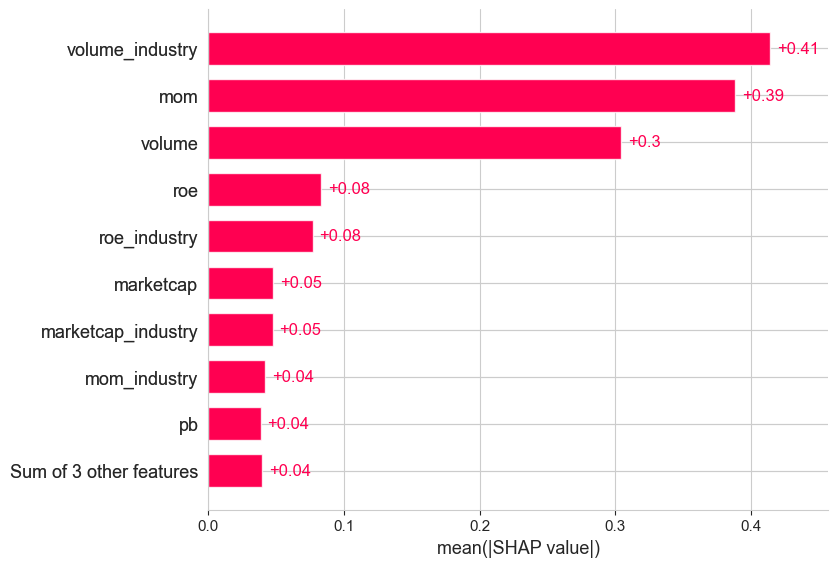

In [16]:
shap.plots.bar(shap_values)

### Look at Shapley values across observations

- Look at Shapley values one feature at a time
- Plot the Shapley value across observations as a function of the feature
- Shaded plot at bottom is histogram of the feature

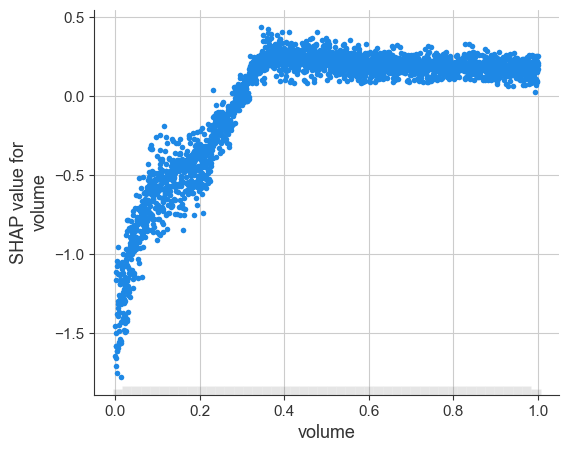

In [17]:
feature = "volume" 
shap.plots.scatter(shap_values[:, feature])

### Extract best, worst, and all stocks in last portfolios

In [18]:
best_last = best[best.date==last_date].copy()
worst_last = worst[worst.date==last_date].copy()
all_last = df2[df2.date==last_date].copy()

best_last["group"] = "best" 
worst_last["group"] = "worst" 
all_last["group"] = "all"

last = pd.concat((best_last, worst_last, all_last))

### Compare features of best, worst, and all portfolios

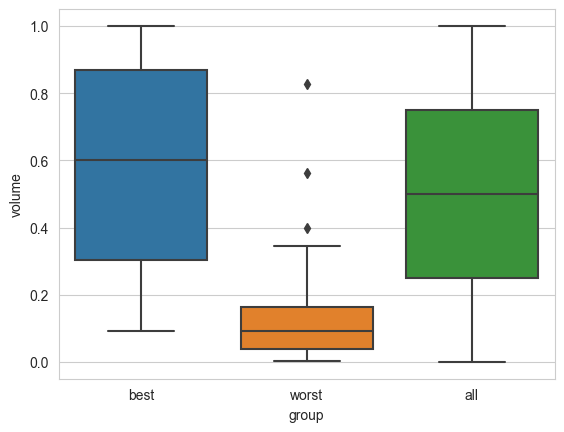

In [19]:
feature = "volume"
sns.boxplot(last, x="group", y=feature)
plt.show()

## 6. Evaluate

### Add SPY returns

In [20]:
import yfinance as yf

spy = yf.download("SPY", start=2017)["Adj Close"]
spy = pd.DataFrame(spy)
spy["date"] = spy.index.map(
    lambda x: x + timedelta(4 - x.weekday())
)
spy = spy.groupby(["date"])["Adj Close"].last()
spy = spy.pct_change()

rets = pd.concat((spy, best_rets, worst_rets), axis=1).dropna()
rets.columns = ["spy", "best", "worst"]


[*********************100%%**********************]  1 of 1 completed


### Return statistics

In [21]:
means = 52 * rets.mean()
stdevs = np.sqrt(52) * rets.std()
rf = 0.05
sharpes = (means - rf) / stdevs
stats = pd.concat((means, stdevs, sharpes), axis=1)
stats.columns = ["mean", "std", "sharpe"]
stats.round(2)

mean   std  sharpe
spy    0.14  0.18    0.52
best   0.35  0.27    1.14
worst -0.29  0.31   -1.08

In [22]:
rets.corr().round(2)

spy  best  worst
spy    1.00  0.43   0.36
best   0.43  1.00   0.61
worst  0.36  0.61   1.00

### Plot performance

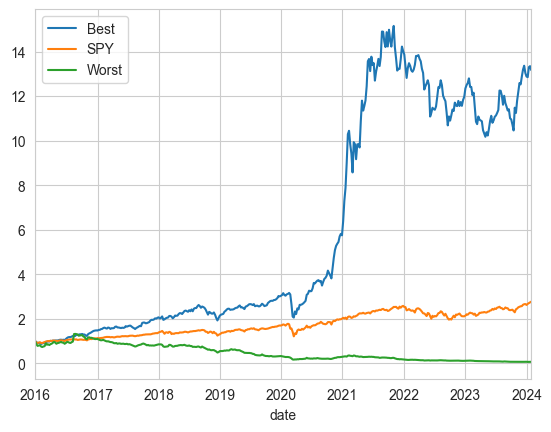

In [23]:
logy = False 

(1+rets.best).cumprod().plot(label="Best", logy=logy)
(1+rets.spy).cumprod().plot(label="SPY", logy=logy)
(1+rets.worst).cumprod().plot(label="Worst", logy=logy)
plt.legend()
plt.show()

### Find frontier of SPY, best, and worst

In [24]:
from cvxopt import matrix
from cvxopt.solvers import qp

cov = rets.cov()
means = rets.mean() 

P = cov
A = np.array(
    [
        means,
        [1., 1., 1.]
    ]
)
P = matrix(P.to_numpy())
q = matrix(np.zeros((3, 1)))
A = matrix(A)

mns = [] 
vars = [] 
ports = []
for targ in np.linspace(0, 0.5/52, 50):
    b = matrix(
        np.array([targ, 1]).reshape(2, 1)
    )
    sol = qp(
        P=P,
        q=q,
        A=A,
        b=b
    )
    w = pd.Series(sol["x"], index=rets.columns)
    mns.append(w @ means)
    vars.append(w @ cov @ w)
    ports.append(w)

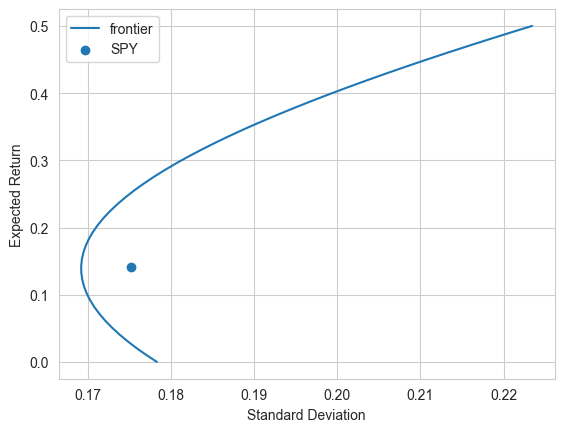

In [25]:
mns = 52 * np.array(mns)
sds = np.sqrt(52*np.array(vars))

plt.plot(sds, mns, label="frontier")
plt.scatter(x=[np.sqrt(52)*rets.spy.std()], y=[52*rets.spy.mean()], label="SPY")
plt.xlabel("Standard Deviation")
plt.ylabel("Expected Return")
plt.legend()
plt.show()

### Find best portfolio with same risk as SPY

In [26]:
stdev = np.max([s for s in sds if s <= np.sqrt(52)*rets.spy.std()])
indx = np.where(sds==stdev)[0].item()
mean = mns[indx]
port = ports[indx]
print(port.round(2))
print(f"portfolio expected return is {mean:.1%}")

spy      0.82
best    -0.05
worst    0.23
dtype: float64
portfolio expected return is 3.1%


### Long-only portfolios of SPY and best

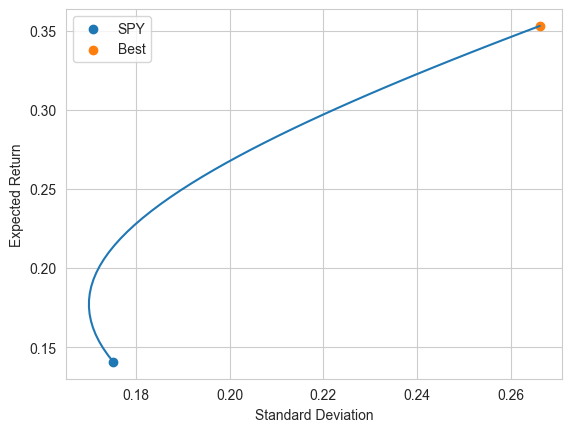

In [27]:
means = rets[["spy", "best"]].mean()
cov = rets[["spy", "best"]].cov()
ports = [np.array([w, 1-w]) for w in np.linspace(0, 1, 50)]
mns = [52 * means @ w for w in ports]
sds = [np.sqrt(52 * w @ cov @ w) for w in ports]

plt.plot(sds, mns, label=None)
plt.scatter(x=[np.sqrt(52)*rets.spy.std()], y=[52*rets.spy.mean()], label="SPY")
plt.scatter(x=[np.sqrt(52)*rets.best.std()], y=[52*rets.best.mean()], label="Best")
plt.xlabel("Standard Deviation")
plt.ylabel("Expected Return")
plt.legend()
plt.show()

### 140/40 portfolio

In [28]:
rets["140/40"] = rets.spy + 0.4*rets.best - 0.4*rets.worst

<AxesSubplot: xlabel='date'>

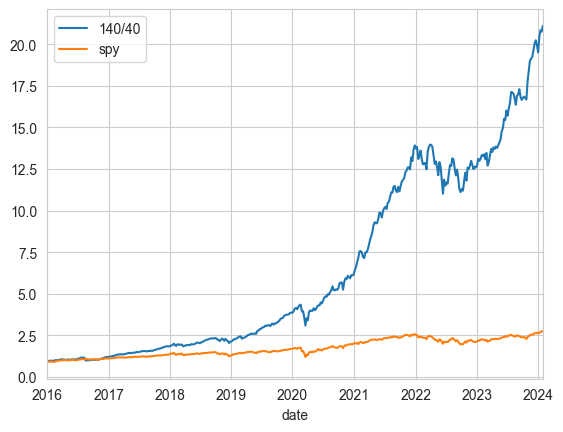

In [29]:
(1+rets[["140/40", "spy"]]).cumprod().plot()

## 7. Train and save

- Train on the most recent train_years of data 
- Save with joblib

In [30]:
from joblib import dump 

dates = df.date.unique()
dates.sort()
date = dates[-52*train_years]
df3 = df[df.date>=date]
model.fit(df3[features], df3["target2"])
dump(model, "mymodel.joblib")

['mymodel.joblib']